In [311]:
import copy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.signal import savgol_filter
import matplotlib.gridspec as gridspec
import os as os

path = "./results/"

The load_curves function loads the results of multiple algorithms across different environments from .npy files, stores them in a dictionary structure, and processes them to ensure the curves all have the same length.

In [312]:
def load_curves(algorithms, envs, t):
    curves = {alg: {e: [] for e in envs} for alg in algorithms} # create a dictionary 
    for alg in algorithms:
        for e in envs:
            for i in range(0, 100):
                if t == 0: name = f"{path}/{alg}_{e}_{i}.npy"
                if t == 1: name = f"{path}/{alg}_{e}_{i}_s.npy"
                
                if os.path.isfile(name):
                    #print(f"{name} loaded", np.load(name).shape)
                    curves[alg][e].append(list(np.load(name)))
            max_size = -1        
            for i in range(len(curves[alg][e])):
                if len(curves[alg][e][i]) > max_size:
                    max_size = len(curves[alg][e][i])
            for i in range(len(curves[alg][e])):
                while len(curves[alg][e][i]) <= max_size:
                    curves[alg][e][i].append(curves[alg][e][i][-1])

            curves[alg][e] = np.array(curves[alg][e]) if len(curves[alg][e]) else np.array([[]])
    
    return curves

The smooth function applies a smoothing technique to the loaded data by averaging over a window of neighboring points, creating a more visually appealing curve by reducing fluctuations.

In [313]:
def smooth(data, length=10):
    data = data.copy()
    pad = copy.deepcopy(data[:, -1, None].repeat(length-1, axis=-1)) # padding the data
    pad_data = np.concatenate((data, pad), axis=-1)
    pad = copy.deepcopy(data[:, 0, None].repeat(length-1, axis=-1))  # padding the data
    pad_data = np.concatenate((pad, pad_data), axis=-1)
    
    for i in range(length, len(data[0])+length):
        assert i-length >= 0
        data[:, i-length] = np.mean(pad_data[:, i-length:i+length], axis=-1) # smooth the data with its average
    return data

Plot the results

In [314]:
def plot_results(ENVS, ALGORITHMS, curves, use_median, sample_rates):
    """
    Plots the performance curves for different algorithms in various environments.
    Parameters:
    - ENVS: List of environment names.
    - ALGORITHMS: List of algorithm names.
    - curves: Dictionary of data for each algorithm and environment.
    - use_median: Boolean; if True, use median with quartiles; if False, use mean with std deviation.
    - sample_rates: Dictionary of sampling rates for each algorithm.
    """
    for e in ENVS:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.set_title(e) # Set environment name as the title
        ax.set_xlabel("Time [hours]") # Label for x-axis in hours
        ax.set_xlabel("Steps [1e4]") # Label for x-axis in steps
        ax.set_ylabel("Success rate" if use_median else "Reward") # Label for y-axis
        
        for i, alg in enumerate(ALGORITHMS):
            c = curves[alg][e] # Get data for the algorithm on this environment
            if c.size == 0:
                print(f"No data for {alg} on {e}. Skipping.")
                continue # Skip if there's no data
            
            # Compute the time axis based on the sampling rate
            x = np.arange(c.shape[1]) / sample_rates[alg]   # for hours
            x = np.arange(c.shape[1]) / 2                   # for steps
            
            if use_median:
                # Compute median, 1st quartile (25th percentile), and 3rd quartile (75th percentile)
                median = smooth(np.median(c, axis=0, keepdims=True), length=2).squeeze() # Smooth median
                q1 = smooth(np.percentile(c, 25, axis=0, keepdims=True), length=2).squeeze() # Smooth 25th percentile
                q3 = smooth(np.percentile(c, 75, axis=0, keepdims=True), length=2).squeeze() # Smooth 75th percentile
                ax.plot(x, median, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot median curve
                ax.fill_between(x, q1, q3, alpha=0.2, color='C' + str(i)) # Fill between 1st and 3rd quartile
            else:
                # Compute mean and standard deviation
                mu = smooth(c.mean(axis=0, keepdims=True), length=2).squeeze() # Smooth mean
                sigma = smooth(c.std(axis=0, keepdims=True), length=2).squeeze() # Smooth std deviation
                ax.plot(x, mu, label=alg, linewidth=4, linestyle='-', color='C' + str(i)) # Plot mean curve
                ax.fill_between(x, mu + sigma, mu - sigma, alpha=0.2, color='C' + str(i)) # Fill between std deviation
        
            ax.set_xticks(np.arange(0, x[-1] + 1, step=1))      # for hours
            ax.set_xticks(np.arange(0, x[-1] + 1, step=10))     # for steps

        ax.grid(True)   # Add grid
        ax.legend()     # Add legend for algorithms
        # ax.set_xlim(0, 10)
        plt.show() # Show the plot

In [315]:
# Define environments and algorithms
ENVS = ['MR-env']
ALGORITHMS = ['OurDDPG', 'ExpD3', 'TD3', 'SAC']

sample_rates = {
    "OurDDPG": 10,  # 10 Hz
    "ExpD3": 15,    # 15 Hz
    "TD3": 8,       # 8 Hz
    "SAC": 5,       # 5 Hz
}

# ENVS = ['MR-env', 'MR-corridor-env']
# ALGORITHMS = ['OurDDPG', 'ExpD3', 'SAC']

Plots the performance curves for each algorithm on each environment.

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_15453/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


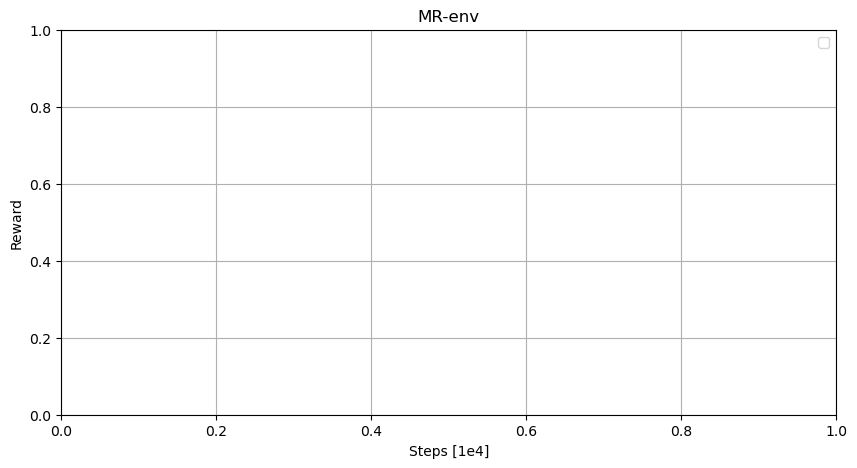

In [316]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 0)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, False, sample_rates)

No data for OurDDPG on MR-env. Skipping.
No data for ExpD3 on MR-env. Skipping.
No data for TD3 on MR-env. Skipping.
No data for SAC on MR-env. Skipping.


/tmp/ipykernel_15453/1552156961.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()     # Add legend for algorithms


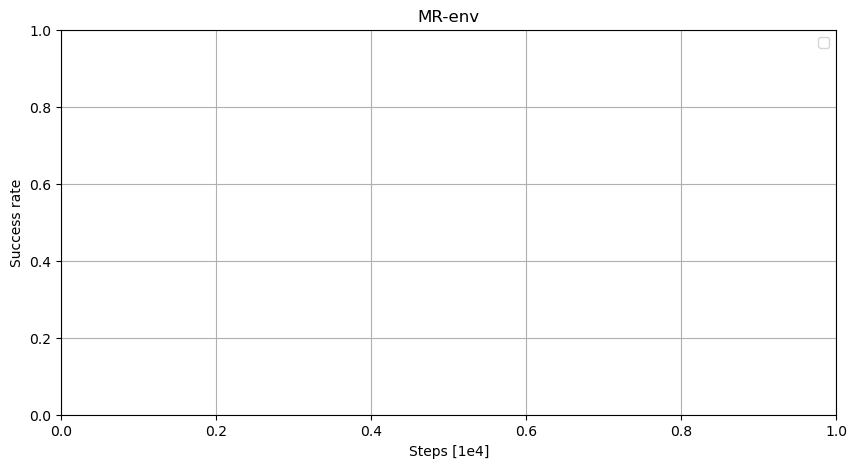

In [317]:
# Load the curves
curves = load_curves(ALGORITHMS, ENVS, t = 1)
# Plot data
plot_results(ENVS, ALGORITHMS, curves, True, sample_rates)

Calculate the time needed to do the experiment, based on the graphs above.

In [318]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evaluation_data(data_path, window_size=10, eval_step=20):
    """
    Plots evaluation rewards and success over time, with optional smoothing.
    
    Parameters:
    - data_path (str): Path to the .npz data file.
    - window_size (int): The window size for smoothing (default is 10).
    - eval_step (int): Step interval for evaluation (default is 20).
    """
    
    # Load the data
    loaded_data = np.load(data_path)
    time = loaded_data['Total_Time_List']  # Assuming this is in seconds
    rewards = loaded_data['Evaluation_Reward_List']
    success = loaded_data['Evaluation_Success_List']

    # Convert time to hours
    time_in_hours = time / 3600

    # Check if the number of data points is sufficient for smoothing
    num_data_points = len(rewards)
    if num_data_points < window_size:
        raise ValueError(f"Insufficient data points for smoothing: {num_data_points} points, but window size is {window_size}.")

    # Smoothing for rewards and success
    smoothed_rewards = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
    padded_rewards = np.pad(smoothed_rewards, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    smoothed_success = np.convolve(success, np.ones(window_size) / window_size, mode='valid')
    padded_success = np.pad(smoothed_success, (window_size // 2, window_size - window_size // 2 - 1), mode='edge')

    # Ensure the time array has the same length as rewards and success
    if len(time_in_hours) != len(rewards) or len(time_in_hours) != len(success):
        raise ValueError("Time array and rewards/success arrays lengths do not match.")

    # Create a figure with two subplots (one below the other)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # Plot rewards on the first subplot
    ax1.plot(time_in_hours, rewards, label="Evaluation Rewards", color='blue', alpha=0.4)
    ax1.plot(time_in_hours, padded_rewards, label="Smoothed Rewards", color='orange')
    ax1.set_ylabel("Reward")
    ax1.set_title("Rewards over Time")
    ax1.legend()
    ax1.grid(True)

    # Plot success on the second subplot
    ax2.plot(time_in_hours, success, label="Evaluation Success", color='green', alpha=0.4)
    ax2.plot(time_in_hours, padded_success, label="Smoothed Success", color='red')
    ax2.set_xlabel("Time (Hours)")
    ax2.set_ylabel("Success")
    ax2.set_title("Success over Time")
    ax2.legend()
    ax2.grid(True)

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


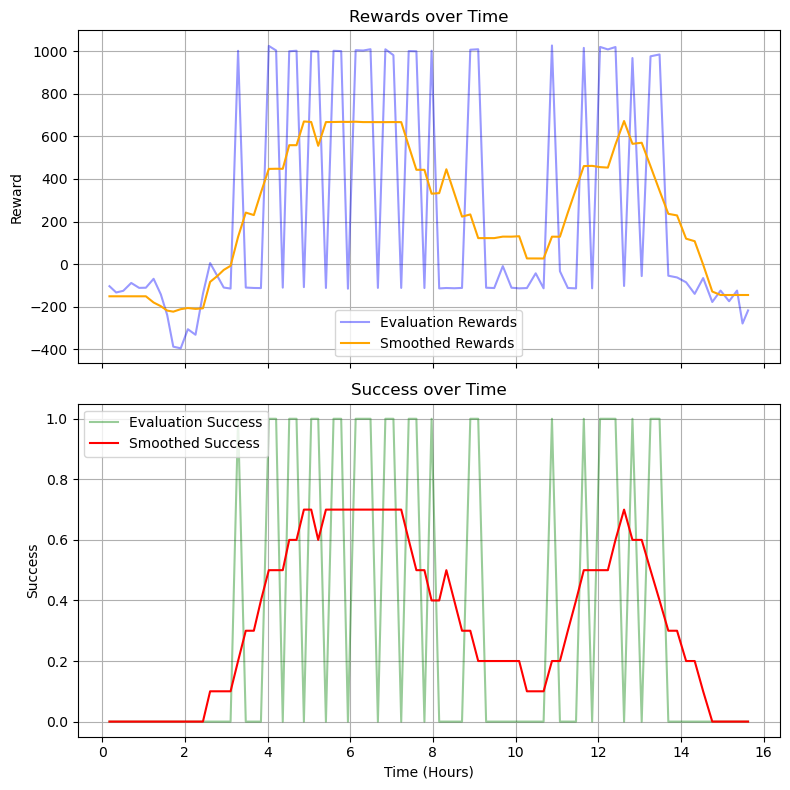

In [319]:
plot_evaluation_data("./results/eval_TD3_64_128_0.npz", window_size=10)

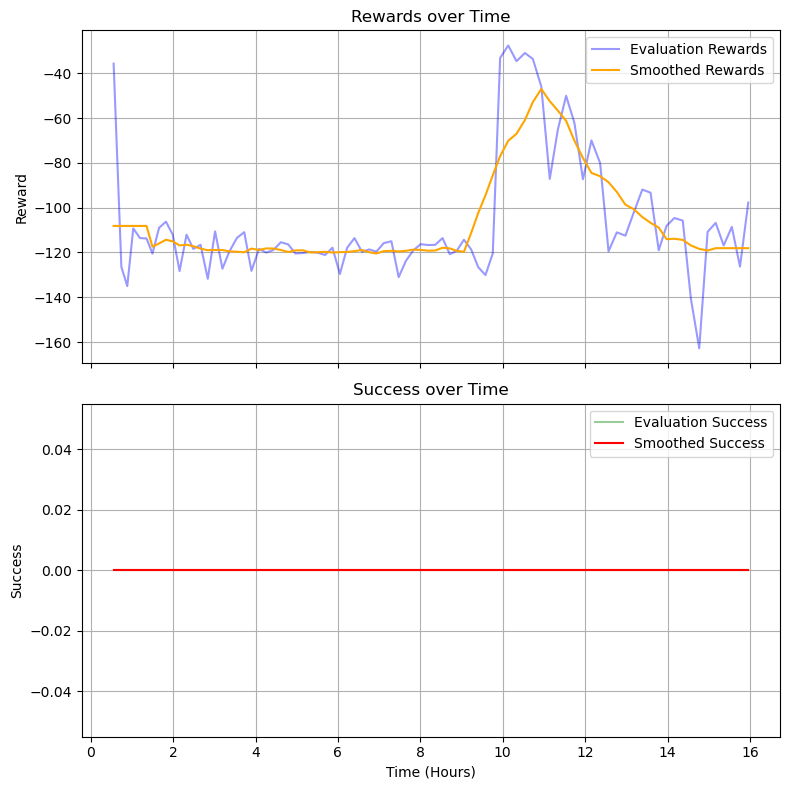

In [320]:
plot_evaluation_data("./results/eval_ExpD3_64_128_0.npz", window_size=10)